In [1]:
# all hyperparameters taken from https://www.sciencedirect.com/science/article/pii/S0165027020303095

import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
left = []
right = []

with open('motion_gui_logs_rachel_1.pickle', 'rb') as f:
    file = pickle.load(f)
    
    event_array = file['EVENT_LOG']
    signal_array = file['DATA_LOG']
    
    j = 0
    for i in tqdm(range(len(event_array)-1)):
        
        event_data = vars(event_array[i])
        next_event_data = vars(event_array[i+1])
        
        # initial time for that event
        time_0 = event_data['timestamp']
        
        # array to store signal for that event
        event_signal = np.array([])
        
        # loop through signal array. While timestamp is less than timestamp
        # of the next event, add it to the current event signal
        while signal_array[j]['time'] <= next_event_data['timestamp']:
            
            # number of points at that timestamp
            n_samples = signal_array[j]['data'].shape[1]
            
            # spread out time between this timestamp and the next
            times = np.linspace(signal_array[j]['time'], signal_array[j+1]['time'], n_samples)
            
            # map each time to a list of channel values
            for time, channel_values in zip(times, signal_array[j]['data'][:8].T):

                # signal at this event timestamp
                signal_at_time = np.array([])

                # populate the current signal array
                for channel in channel_values:
                    point = np.array([time - time_0, channel])
                    signal_at_time = np.vstack((signal_at_time, point)) \
                                            if signal_at_time.size else point
                    
                # add another dimension to signal_at_time for formatting
                signal_at_time = np.expand_dims(signal_at_time, axis=1)
                    
                # add the signal at the current time to the event signal
                event_signal = np.concatenate((event_signal, signal_at_time), axis=1) \
                                            if event_signal.size else signal_at_time
            
            # next timestamp in signal array
            j += 1
            
        # add it to either left or right data
        if event_signal.size == 0:
            continue
  
        if event_data['task'] == 'LEFT':
            left.append(event_signal)
                
        elif event_data['task'] == 'RIGHT':
            right.append(event_signal)
                
    # add remaining not needed since last event is end


100%|█████████████████████████████████████████| 105/105 [00:03<00:00, 27.12it/s]


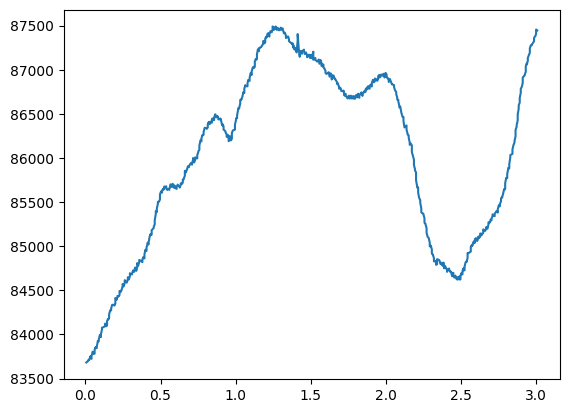

In [3]:
# format: left[event_number][channel_number][index][time, value]

# Let's extract a single channel from a single event
t = left[3][4][:, 0]
x = left[3][4][:, 1]

plt.plot(t, x)

/home/nathan/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Filtered Data')

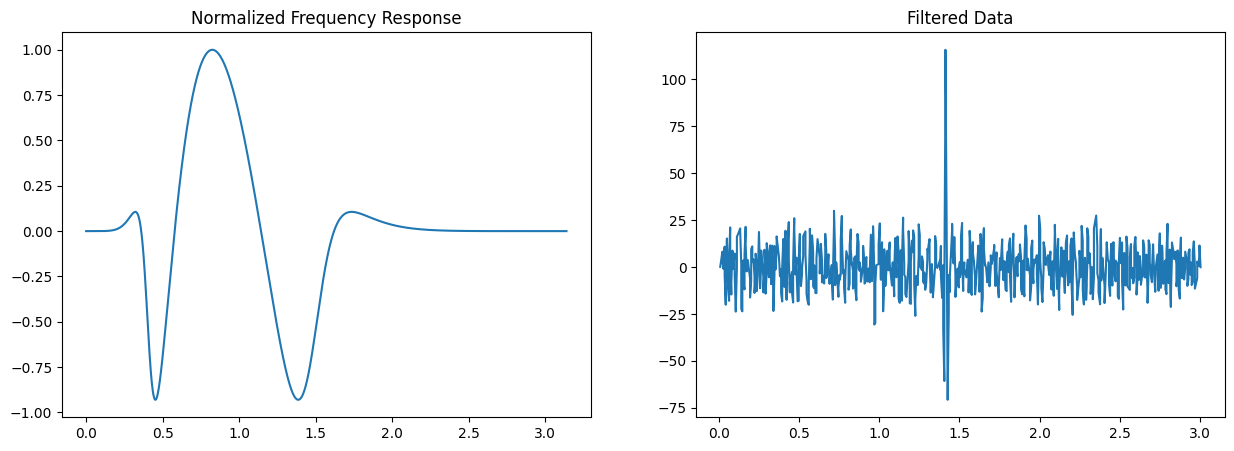

In [4]:
# Butterworth Bandpass Filter
# Taken from https://stackoverflow.com/a/48677312

from scipy.signal import butter, freqz, sosfiltfilt, sosfreqz

# Sample rate and desired cutoff frequencies (in Hz).
fs = 125
lowcut = 8
highcut = 30

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfiltfilt(sos, data)
        return y

sos = butter_bandpass(lowcut, highcut, fs)
w, h = sosfreqz(sos, worN=2000)

y = butter_bandpass_filter(x, lowcut, highcut, fs)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].plot(w, h)
ax[0].set_title("Normalized Frequency Response")

ax[1].plot(t, y)
ax[1].set_title("Filtered Data")

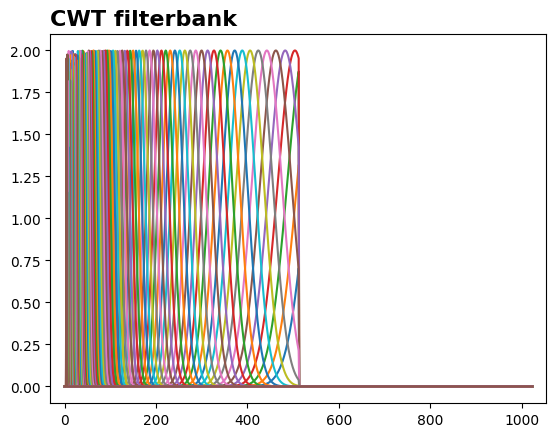

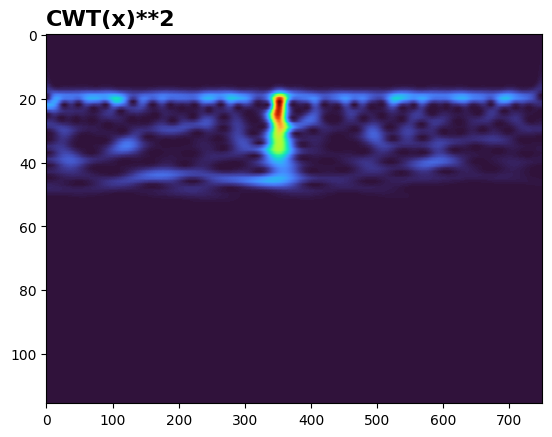

In [5]:
# Continuous Wavelet Transform
# Taken from https://dsp.stackexchange.com/a/87760

from ssqueezepy import Wavelet, cwt
from ssqueezepy.utils import make_scales, cwt_scalebounds
from ssqueezepy.visuals import plot, imshow

# configure
signal_length = len(y)
wavelet = Wavelet(('gmw', {'gamma': 3, 'beta': 60}))

# make scales
min_scale, max_scale = cwt_scalebounds(wavelet, signal_length)
scales = make_scales(signal_length, scaletype='log-piecewise', nv=16, # log-piecewise and 16 voices recommended by library
                     min_scale=min_scale, max_scale=max_scale, wavelet=wavelet)

# make filterbank
fbank = wavelet(scale=scales)

# take CWT
wx, _ = cwt(y, wavelet, scales=scales)

# square it
wx = wx ** 2

# visualize
plot(fbank.T, show=1, title="CWT filterbank")
imshow(wx, title="CWT(x)**2", abs=True)